In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import datetime
import calendar

In [ ]:
df = pd.read_csv(r"G:\MJI\SKZ\Script\From RAJ\TmaxData.csv")

In [ ]:
df

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df

In [ ]:
df['date'].dt.year

In [ ]:
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day
df

In [ ]:
ts_conditions = [
                (df['date'].dt.year > 1984) & (df['date'].dt.year <= 2014),
                (df['date'].dt.year > 2014) & (df['date'].dt.year <= 2044),
                (df['date'].dt.year > 2044) & (df['date'].dt.year <= 2074),
                 df['date'].dt.year > 2074
                ]

ts_choices = ['Base', 'Short', 'Mid', 'Long']

season_conditions = [
                     (df['date'].dt.month > 2) & (df['date'].dt.month <= 5),
                     (df['date'].dt.month > 5) & (df['date'].dt.month <= 9),
                     (df['date'].dt.month > 9) & (df['date'].dt.month <= 11),
                     (df['date'].dt.month.isin([1, 2, 12]))
                    ]

season_choices = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']

df['time_span'] = np.select(ts_conditions, ts_choices, default='historical')
df['Season'] = np.select(season_conditions, season_choices, default='None')
df['Spatial_Mean']= df[df.columns[1:-8]].mean(axis=1)
spatial_mean_df = df[['time_span', 'model', 'projection', 'Season', 'Year', 'Month', 'Day', 'date', 'Spatial_Mean']]
spatial_mean_df

In [ ]:
annual_season_mean_df = spatial_mean_df.groupby(['time_span', 'model', 'projection', 'Year', 'Season'])['Spatial_Mean'].mean().reset_index()
annual_season_mean_df

In [ ]:
annual_season_mean_df.rename({'Spatial_Mean' : 'Annual_Seasonal_Mean'}, inplace = True, axis=1)

In [ ]:
annual_season_mean_df

In [ ]:
selected_seasonal_df = annual_season_mean_df[annual_season_mean_df['Year']> 1984]
selected_seasonal_df

In [ ]:
seasonal_mean_df = selected_seasonal_df.groupby(['time_span', 'model', 'projection', 'Season'])['Annual_Seasonal_Mean'].mean().reset_index()
seasonal_mean_df

In [ ]:
model_base_df = seasonal_mean_df[seasonal_mean_df['projection'] == 'historical']
merged_seasonal_mean_df = pd.merge(seasonal_mean_df, model_base_df[['model', 'Season', 'Annual_Seasonal_Mean']], on=['model', 'Season'], suffixes=('', '_base'))
change = ((merged_seasonal_mean_df['Annual_Seasonal_Mean'] - merged_seasonal_mean_df['Annual_Seasonal_Mean_base']))
merged_seasonal_mean_df['Change (°C)'] = change
merged_seasonal_mean_df

In [ ]:
merged_seasonal_mean_df = merged_seasonal_mean_df[merged_seasonal_mean_df['Change (°C)'] != 0]
merged_seasonal_mean_df

In [ ]:
for timespan in ['Short', 'Mid', 'Long']:
    timespan_df = merged_seasonal_mean_df[merged_seasonal_mean_df['time_span'] == timespan]

In [ ]:
xmin = timespan_df['Change (°C)'].min()
xmax = timespan_df['Change (°C)'].max()
print(xmin)
print(xmax)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
font = {'family' : 'Times New Roman',              
        'weight' : 'normal',  
        'size'   : 10}

plt.rc('font',**font)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

hue_order = ['ssp245', 'ssp585']
# custom_palette = ["aqua", "salmon"]

sns.barplot(data=timespan_df, x='Change (°C)', y='Season', hue='projection', errorbar=None, hue_order = hue_order,
            estimator='mean', ax = ax)
ax.axvline(0, color='black', linewidth=1, linestyle='--', c='dimgrey')

# handles, labels = ax.get_legend_handles_labels()
# legend = ax.legend(handles, ['SSP245', 'SSP585'], title='Scenarios', loc='upper left', bbox_to_anchor=(0, 1))
# # legend.get_title().set_fontsize(10)
# legend.get_title().set_fontweight('bold')
# legend.get_title().set_horizontalalignment('left')

ax.set_title(f'{timespan}', fontweight='bold')
ax.set_xlabel('Precipitation Change (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model',  fontsize=12, fontweight='bold')

In [ ]:
min_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].min().reset_index()
min_seasonal_model_df

In [ ]:
max_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].max().reset_index()
max_seasonal_model_df

In [ ]:
merged_max_min_df = pd.merge(min_seasonal_model_df, max_seasonal_model_df, on=['time_span', 'projection', 'Season'], suffixes=('', '_max'))
merged_max_min_df['Difference'] = merged_max_min_df['Change (°C)_max'] - merged_max_min_df['Change (°C)']
merged_max_min_df

In [ ]:
for scenario in ['ssp245', 'ssp585']:
    scenarion_df = merged_max_min_df[merged_max_min_df['projection'] == scenario]

    for timespan in ['Short', 'Mid', 'Long']:
        timespan_df = scenarion_df[scenarion_df['time_span'] == timespan]

In [ ]:
timespan_df

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
font = {'family' : 'Times New Roman',              
        'weight' : 'normal',  
        'size'   : 10}

plt.rc('font',**font)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

# Create range horizontal bar plot (left = low value, width = amplitude)
ax.barh(timespan_df['Season'], timespan_df['Difference'], left=timespan_df['Change (°C)'], color='deepskyblue', edgecolor='black', alpha=0.9, height=0.2)
# ax.axvline(0, color='black', linewidth=1, linestyle='--', c='dimgrey')

ax.tick_params(axis='y', labelrotation=90)
for label in ax.get_yticklabels():
    label.set_verticalalignment('center')

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.set_xticklabels(list(ax.get_xticks()))
               
# Set labels and title
ax.set_title('Long-term (2075-2100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Seasonal Changes in Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Season', fontsize=12, fontweight='bold')
ax.set_xlim(0, 6)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar

df = pd.read_csv(r"G:\MJI\SKZ\Script\From RAJ\TmaxData.csv")
df['date'] = pd.to_datetime(df['date'])

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

timespan_dict = {'Base': [1985, 2014],
                 'Short': [2015, 2044],
                 'Mid': [2045, 2074],
                 'Long': [2075, 2100]}

ts_conditions = [
                (df['date'].dt.year >= timespan_dict['Base'][0]) & (df['date'].dt.year <= timespan_dict['Base'][1]),
                (df['date'].dt.year >= timespan_dict['Short'][0]) & (df['date'].dt.year <= timespan_dict['Short'][1]),
                (df['date'].dt.year >= timespan_dict['Mid'][0]) & (df['date'].dt.year <= timespan_dict['Mid'][1]),
                (df['date'].dt.year >= timespan_dict['Long'][0]) & (df['date'].dt.year <= timespan_dict['Long'][1])
                ]

ts_choices = list(timespan_dict.keys())

season_conditions = [
                     (df['date'].dt.month > 2) & (df['date'].dt.month <= 5),
                     (df['date'].dt.month > 5) & (df['date'].dt.month <= 9),
                     (df['date'].dt.month > 9) & (df['date'].dt.month <= 11),
                     (df['date'].dt.month.isin([1, 2, 12]))
                    ]

season_choices = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']

df['time_span'] = np.select(ts_conditions, ts_choices, default='historical')
df['Season'] = np.select(season_conditions, season_choices, default='None')
df['Spatial_Mean']= df[df.columns[1:-8]].mean(axis=1)
spatial_mean_df = df[['time_span', 'model', 'projection', 'Season', 'Year', 'Month', 'Day', 'date', 'Spatial_Mean']]

annual_season_mean_df = spatial_mean_df.groupby(['time_span', 'model', 'projection', 'Year', 'Season'])['Spatial_Mean'].mean().reset_index()
annual_season_mean_df.rename({'Spatial_Mean' : 'Annual_Seasonal_Mean'}, inplace = True, axis=1)

selected_seasonal_df = annual_season_mean_df[annual_season_mean_df['Year']> 1984]
seasonal_mean_df = selected_seasonal_df.groupby(['time_span', 'model', 'projection', 'Season'])['Annual_Seasonal_Mean'].mean().reset_index()

model_base_df = seasonal_mean_df[seasonal_mean_df['projection'] == 'historical']
merged_seasonal_mean_df = pd.merge(seasonal_mean_df, model_base_df[['model', 'Season', 'Annual_Seasonal_Mean']], on=['model', 'Season'], suffixes=('', '_base'))
change = ((merged_seasonal_mean_df['Annual_Seasonal_Mean'] - merged_seasonal_mean_df['Annual_Seasonal_Mean_base']))
merged_seasonal_mean_df['Change (°C)'] = change

min_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].min().reset_index()
max_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].max().reset_index()
merged_max_min_df = pd.merge(min_seasonal_model_df, max_seasonal_model_df, on=['time_span', 'projection', 'Season'], suffixes=('', '_max'))
merged_max_min_df['Difference'] = merged_max_min_df['Change (°C)_max'] - merged_max_min_df['Change (°C)']


for scenario in ['ssp245', 'ssp585']:
    scenarion_df = merged_max_min_df[merged_max_min_df['projection'] == scenario]

    n_cols = 3
    n_rows = 1
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 4))
    ax = ax.flatten()  
    
    font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 8}
    plt.rc('font', **font)
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)

    j = 0
    for timespan in ['Short', 'Mid', 'Long']:
        timespan_df = scenarion_df[scenarion_df['time_span'] == timespan]

        # Calculate the subplot index
        r, c = divmod(j, n_cols)
        ax_index = r * n_cols + c
    
        # Create range horizontal bar plot (left = low value, width = amplitude)
        ax[ax_index].barh(timespan_df['Season'], timespan_df['Difference'], left=timespan_df['Change (°C)'], color='crimson', edgecolor='black', alpha=0.9, height=0.2)
        # ax[ax_index].axvline(0, color='black', linewidth=1, linestyle='--', c='dimgrey')
        
        ax[ax_index].tick_params(axis='y', labelrotation=90)
        for label in ax[ax_index].get_yticklabels():
            label.set_verticalalignment('center')
        
        ax[ax_index].xaxis.set_minor_locator(tck.AutoMinorLocator())
        # ax.set_xticklabels(list(ax.get_xticks()))
                       
        # Set labels and title
        ax[ax_index].set_xlim(-1, 6)
        ax[ax_index].set_title(f'{timespan}-term ({timespan_dict[timespan][0]}-{timespan_dict[timespan][1]})', fontsize=12, fontweight='bold')
        ax[ax_index].set_xlabel('Seasonal Change in Temperature (°C)', fontsize=10, fontweight='normal')
        ax[ax_index].set_ylabel('Season', fontsize=10, fontweight='normal')
        
        j = j +1

    fig.suptitle(f'Changes in Seasonal Temperature ({scenario.upper()})', fontweight= 'bold', fontsize=14, x=0.51, y = 0.98)
    plt.tight_layout()
    # plt.savefig(f'Output/Analysis/Seasonal_{scenario}All_Model_Change_Range_Comaparison.jpg', dpi=300, bbox_inches = 'tight')

In [ ]:
for timespan in ['Short', 'Mid', 'Long']:
    timespan_df = merged_max_min_df[merged_max_min_df['time_span'] == timespan]

    ssp245_df = timespan_df[timespan_df['projection'] == 'ssp245']
    ssp585_df = timespan_df[timespan_df['projection'] == 'ssp585']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 10}

plt.rc('font', **font)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

height = -0.28  # Adjusted height for the bars to avoid overlap

# Custom season order (for example: Winter, Pre-Monsoon, Monsoon, Post-Monsoon)
season_order = ['Winter', 'Pre-Monsoon', 'Monsoon', 'Post-Monsoon']

# Manually map seasons to a numeric value based on the custom order
ssp245_df['Season_numeric'] = pd.Categorical(ssp245_df['Season'], categories=season_order, ordered=True).codes
ssp585_df['Season_numeric'] = pd.Categorical(ssp585_df['Season'], categories=season_order, ordered=True).codes

# Plot for ssp245_df
ax.barh(ssp245_df['Season_numeric'], ssp245_df['Difference'], 
        left=ssp245_df['Change (°C)'], color='gold', edgecolor='black', alpha=0.9, height=0.25, label='SSP245')

# Plot for ssp585_df (offset by height to avoid overlap)
ax.barh(ssp585_df['Season_numeric'] + height, ssp585_df['Difference'], 
        left=ssp585_df['Change (°C)'], color='red', edgecolor='black', alpha=0.9, height=0.25, label='SSP585')

# Set y-ticks to the original 'Season' labels
ax.set_yticks(ssp245_df['Season_numeric'] + height / 2)  # Centering the y-ticks between the two bars
ax.set_yticklabels(ssp245_df['Season'])

# Add vertical line at x=0
# ax.axvline(0, color='black', linewidth=1, linestyle='--', c='dimgrey')

# Rotate y-axis labels vertically and center them
ax.tick_params(axis='y', labelrotation=30)
for label in ax.get_yticklabels():
    label.set_verticalalignment('center_baseline')

# Set minor ticks on x-axis
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

# Add a legend to differentiate between the two datasets
ax.legend(title="Scenarios")

# Set labels and title
ax.set_title('Long-term (2075-2100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Seasonal Changes in Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Season', fontsize=12, fontweight='bold')

# Adjust x-axis limits to ensure both datasets are fully visible
ax.set_xlim(-1, 6)

In [ ]:
ssp585_df['Season_numeric'] = pd.factorize(ssp585_df['Season'])[0]
ssp585_df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import datetime
import calendar

df = pd.read_csv(r"G:\MJI\SKZ\Script\From RAJ\TminData.csv")
df['date'] = pd.to_datetime(df['date'])

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

timespan_dict = {'Base': [1990, 2014],
                 'Near': [2026, 2050],
                 'Mid': [2051, 2075],
                 'Long': [2076, 2100]}

ts_conditions = [
                (df['date'].dt.year >= timespan_dict['Base'][0]) & (df['date'].dt.year <= timespan_dict['Base'][1]),
                (df['date'].dt.year >= timespan_dict['Near'][0]) & (df['date'].dt.year <= timespan_dict['Near'][1]),
                (df['date'].dt.year >= timespan_dict['Mid'][0]) & (df['date'].dt.year <= timespan_dict['Mid'][1]),
                (df['date'].dt.year >= timespan_dict['Long'][0]) & (df['date'].dt.year <= timespan_dict['Long'][1])
                ]

ts_choices = list(timespan_dict.keys())

season_conditions = [
                     (df['date'].dt.month > 2) & (df['date'].dt.month <= 5),
                     (df['date'].dt.month > 5) & (df['date'].dt.month <= 9),
                     (df['date'].dt.month > 9) & (df['date'].dt.month <= 11),
                     (df['date'].dt.month.isin([1, 2, 12]))
                    ]

season_choices = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']

df['time_span'] = np.select(ts_conditions, ts_choices, default='historical')
df['Season'] = np.select(season_conditions, season_choices, default='None')
df['Spatial_Mean']= df[df.columns[1:-8]].mean(axis=1)
spatial_mean_df = df[['time_span', 'model', 'projection', 'Season', 'Year', 'Month', 'Day', 'date', 'Spatial_Mean']]

annual_season_mean_df = spatial_mean_df.groupby(['time_span', 'model', 'projection', 'Year', 'Season'])['Spatial_Mean'].mean().reset_index()
annual_season_mean_df.rename({'Spatial_Mean' : 'Annual_Seasonal_Mean'}, inplace = True, axis=1)

selected_seasonal_df = annual_season_mean_df[annual_season_mean_df['Year']> 1984]
seasonal_mean_df = selected_seasonal_df.groupby(['time_span', 'model', 'projection', 'Season'])['Annual_Seasonal_Mean'].mean().reset_index()

model_base_df = seasonal_mean_df[seasonal_mean_df['projection'] == 'historical']
merged_seasonal_mean_df = pd.merge(seasonal_mean_df, model_base_df[['model', 'Season', 'Annual_Seasonal_Mean']], on=['model', 'Season'], suffixes=('', '_base'))
change = ((merged_seasonal_mean_df['Annual_Seasonal_Mean'] - merged_seasonal_mean_df['Annual_Seasonal_Mean_base']))
merged_seasonal_mean_df['Change (°C)'] = change

min_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].min().reset_index()
max_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].max().reset_index()
merged_max_min_df = pd.merge(min_seasonal_model_df, max_seasonal_model_df, on=['time_span', 'projection', 'Season'], suffixes=('', '_max'))
merged_max_min_df['Difference'] = merged_max_min_df['Change (°C)_max'] - merged_max_min_df['Change (°C)']

n_cols = 3
n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 4))
ax = ax.flatten()  

font = {'family': 'Times New Roman', 
        'weight': 'normal', 
        'size': 8}
plt.rc('font', **font)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

j = 0
for timespan in ['Near', 'Mid', 'Long']:
    timespan_df = merged_max_min_df[merged_max_min_df['time_span'] == timespan]

    ssp245_df = timespan_df[timespan_df['projection'] == 'ssp245']
    ssp585_df = timespan_df[timespan_df['projection'] == 'ssp585']

    # Calculate the subplot index
    r, c = divmod(j, n_cols)
    ax_index = r * n_cols + c

    height = -0.20  # Adjusted height for the bars to avoid overlap
    
    # Custom season order (for example: Winter, Pre-Monsoon, Monsoon, Post-Monsoon)
    season_order = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon','Winter']
    
    # Manually map seasons to a numeric value based on the custom order
    ssp245_df['Season_numeric'] = pd.Categorical(ssp245_df['Season'], categories=season_order, ordered=True).codes
    ssp585_df['Season_numeric'] = pd.Categorical(ssp585_df['Season'], categories=season_order, ordered=True).codes
        
    # Plot for ssp245_df
    ax[ax_index].barh(ssp245_df['Season_numeric'], ssp245_df['Difference'], 
                      left=ssp245_df['Change (°C)'], color='chocolate', edgecolor='black', alpha=0.9, height=0.15, label='SSP245')
    
    # Plot for ssp585_df (offset by height to avoid overlap)
    ax[ax_index].barh(ssp585_df['Season_numeric'] + height, ssp585_df['Difference'], 
                      left=ssp585_df['Change (°C)'], color='red', edgecolor='black', alpha=0.9, height=0.15, label='SSP585')

    # Add vertical line at x=0
    ax[ax_index].axvline(0, color='black', linewidth=1, linestyle='dotted', c='dimgrey')
    
    # Set y-ticks to the original 'Season' labels
    ax[ax_index].set_yticks(ssp245_df['Season_numeric'] + height / 2)  # Centering the y-ticks between the two bars
    ax[ax_index].set_yticklabels(ssp245_df['Season'])
    
    ax[ax_index].tick_params(axis='y', labelrotation=30)
    for label in ax[ax_index].get_yticklabels():
        label.set_verticalalignment('center_baseline')
    
    ax[ax_index].xaxis.set_minor_locator(tck.AutoMinorLocator())
    # ax.set_xticklabels(list(ax.get_xticks()))

    # Add a legend to differentiate between the two datasets
    ax[ax_index].legend(title="Scenarios")

    # Set labels and title
    ax[ax_index].set_xlim(-0.5, 8)
    ax[ax_index].set_title(f'{timespan}-term ({timespan_dict[timespan][0]}-{timespan_dict[timespan][1]})', fontsize=12, fontweight='bold')
    ax[ax_index].set_xlabel('Change in Minimum Temperature (°C)', fontsize=10, fontweight='normal')
    ax[ax_index].set_ylabel('Season', fontsize=10, fontweight='normal')
    
    j = j +1

fig.suptitle(f'Seasonal Change in Minimum Temperature', fontweight= 'bold', fontsize=14, x=0.535, y = 0.97)
plt.tight_layout()
# plt.savefig(f'G:\MJI\SKZ\Script\From RAJ\Output\Analysis\Precipitation\Seasonal_All_Model_Change_Range_Comaparison.jpg', dpi=300, bbox_inches = 'tight')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import datetime
import calendar

df = pd.read_csv(r"G:\MJI\SKZ\Script\From RAJ\TminData.csv")
df['date'] = pd.to_datetime(df['date'])

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

timespan_dict = {'Base': [1990, 2014],
                 'Near': [2026, 2050],
                 'Mid': [2051, 2075],
                 'Long': [2076, 2100]}

ts_conditions = [
                (df['date'].dt.year >= timespan_dict['Base'][0]) & (df['date'].dt.year <= timespan_dict['Base'][1]),
                (df['date'].dt.year >= timespan_dict['Near'][0]) & (df['date'].dt.year <= timespan_dict['Near'][1]),
                (df['date'].dt.year >= timespan_dict['Mid'][0]) & (df['date'].dt.year <= timespan_dict['Mid'][1]),
                (df['date'].dt.year >= timespan_dict['Long'][0]) & (df['date'].dt.year <= timespan_dict['Long'][1])
                ]

ts_choices = list(timespan_dict.keys())

season_conditions = [
                     (df['date'].dt.month > 2) & (df['date'].dt.month <= 5),
                     (df['date'].dt.month > 5) & (df['date'].dt.month <= 9),
                     (df['date'].dt.month > 9) & (df['date'].dt.month <= 11),
                     (df['date'].dt.month.isin([1, 2, 12]))
                    ]

season_choices = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']

df['time_span'] = np.select(ts_conditions, ts_choices, default='historical')
df['Season'] = np.select(season_conditions, season_choices, default='None')
df['Spatial_Mean']= df[df.columns[1:-8]].mean(axis=1)
spatial_mean_df = df[['time_span', 'model', 'projection', 'Season', 'Year', 'Month', 'Day', 'date', 'Spatial_Mean']]

annual_season_mean_df = spatial_mean_df.groupby(['time_span', 'model', 'projection', 'Year', 'Season'])['Spatial_Mean'].mean().reset_index()
annual_season_mean_df.rename({'Spatial_Mean' : 'Annual_Seasonal_Mean'}, inplace = True, axis=1)

selected_seasonal_df = annual_season_mean_df[annual_season_mean_df['Year']> 1984]
seasonal_mean_df = selected_seasonal_df.groupby(['time_span', 'model', 'projection', 'Season'])['Annual_Seasonal_Mean'].mean().reset_index()

model_base_df = seasonal_mean_df[seasonal_mean_df['projection'] == 'historical']
merged_seasonal_mean_df = pd.merge(seasonal_mean_df, model_base_df[['model', 'Season', 'Annual_Seasonal_Mean']], on=['model', 'Season'], suffixes=('', '_base'))
change = ((merged_seasonal_mean_df['Annual_Seasonal_Mean'] - merged_seasonal_mean_df['Annual_Seasonal_Mean_base']))
merged_seasonal_mean_df['Change (°C)'] = change

min_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].min().reset_index()
max_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].max().reset_index()
merged_max_min_df = pd.merge(min_seasonal_model_df, max_seasonal_model_df, on=['time_span', 'projection', 'Season'], suffixes=('', '_max'))
merged_max_min_df['Difference'] = merged_max_min_df['Change (°C)_max'] - merged_max_min_df['Change (°C)']

n_cols = 1
n_rows = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4, 10))
ax = ax.flatten()  

font = {'family': 'Times New Roman', 
        'weight': 'normal', 
        'size': 8}
plt.rc('font', **font)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

j = 0
for timespan in ['Near', 'Mid', 'Long']:
    timespan_df = merged_max_min_df[merged_max_min_df['time_span'] == timespan]

    ssp245_df = timespan_df[timespan_df['projection'] == 'ssp245']
    ssp585_df = timespan_df[timespan_df['projection'] == 'ssp585']

    # Calculate the subplot index
    r, c = divmod(j, n_cols)
    ax_index = r * n_cols + c

    height = -0.20  # Adjusted height for the bars to avoid overlap
    
    # Custom season order (for example: Winter, Pre-Monsoon, Monsoon, Post-Monsoon)
    season_order = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon','Winter']
    
    # Manually map seasons to a numeric value based on the custom order
    ssp245_df['Season_numeric'] = pd.Categorical(ssp245_df['Season'], categories=season_order, ordered=True).codes
    ssp585_df['Season_numeric'] = pd.Categorical(ssp585_df['Season'], categories=season_order, ordered=True).codes
        
    # Plot for ssp245_df
    ax[ax_index].barh(ssp245_df['Season_numeric'], ssp245_df['Difference'], 
                      left=ssp245_df['Change (°C)'], color='chocolate', edgecolor='black', alpha=0.9, height=0.15, label='SSP245')
    
    # Plot for ssp585_df (offset by height to avoid overlap)
    ax[ax_index].barh(ssp585_df['Season_numeric'] + height, ssp585_df['Difference'], 
                      left=ssp585_df['Change (°C)'], color='red', edgecolor='black', alpha=0.9, height=0.15, label='SSP585')

    # Add vertical line at x=0
    ax[ax_index].axvline(0, color='black', linewidth=1, linestyle='dotted', c='dimgrey')
    
    # Set y-ticks to the original 'Season' labels
    ax[ax_index].set_yticks(ssp245_df['Season_numeric'] + height / 2)  # Centering the y-ticks between the two bars
    ax[ax_index].set_yticklabels(ssp245_df['Season'])
    
    ax[ax_index].tick_params(axis='y', labelrotation=30)
    for label in ax[ax_index].get_yticklabels():
        label.set_verticalalignment('center_baseline')
    
    ax[ax_index].xaxis.set_minor_locator(tck.AutoMinorLocator())
    # ax.set_xticklabels(list(ax.get_xticks()))

    # Add a legend to differentiate between the two datasets
    ax[ax_index].legend(title="Scenarios")

    # Set labels and title
    ax[ax_index].set_xlim(-2, 10)
    ax[ax_index].set_title(f'{timespan}-term ({timespan_dict[timespan][0]}-{timespan_dict[timespan][1]})', fontsize=12, fontweight='bold')
    ax[ax_index].set_xlabel('Change in Minimum Temperature (°C)', fontsize=10, fontweight='normal')
    ax[ax_index].set_ylabel('Season', fontsize=10, fontweight='normal')
    
    j = j +1

fig.suptitle(f'Minimum Temperature', fontweight= 'bold', fontsize=14, x=0.605, y = 0.985)
plt.tight_layout()
plt.savefig(f'G:\MJI\SKZ\Script\From RAJ\Output\Analysis\Tmin_Seasonal_All_Model_Change_Range_Comaparison.jpg', dpi=300, bbox_inches = 'tight')

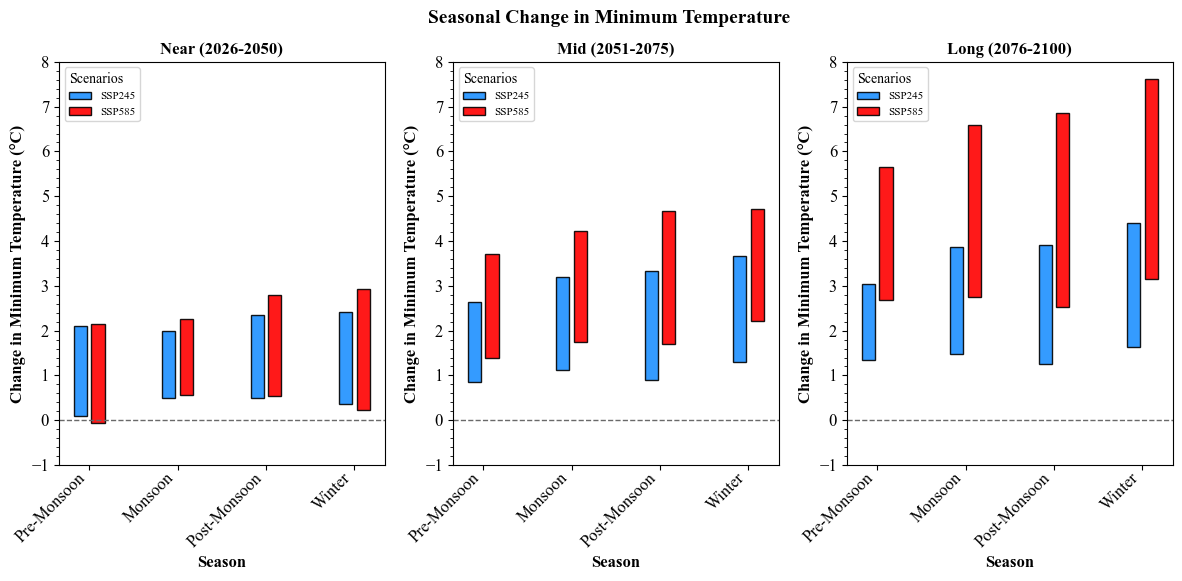

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import datetime
import calendar

df = pd.read_csv(r"D:\Script\From_RAJ\Code\TminData.csv")
df['date'] = pd.to_datetime(df['date'])

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

timespan_dict = {'Base': [1990, 2014],
                 'Near': [2026, 2050],
                 'Mid': [2051, 2075],
                 'Long': [2076, 2100]}

ts_conditions = [
                (df['date'].dt.year >= timespan_dict['Base'][0]) & (df['date'].dt.year <= timespan_dict['Base'][1]),
                (df['date'].dt.year >= timespan_dict['Near'][0]) & (df['date'].dt.year <= timespan_dict['Near'][1]),
                (df['date'].dt.year >= timespan_dict['Mid'][0]) & (df['date'].dt.year <= timespan_dict['Mid'][1]),
                (df['date'].dt.year >= timespan_dict['Long'][0]) & (df['date'].dt.year <= timespan_dict['Long'][1])
                ]

ts_choices = list(timespan_dict.keys())

season_conditions = [
                     (df['date'].dt.month > 2) & (df['date'].dt.month <= 5),
                     (df['date'].dt.month > 5) & (df['date'].dt.month <= 9),
                     (df['date'].dt.month > 9) & (df['date'].dt.month <= 11),
                     (df['date'].dt.month.isin([1, 2, 12]))
                    ]

season_choices = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']

df['time_span'] = np.select(ts_conditions, ts_choices, default='historical')
df['Season'] = np.select(season_conditions, season_choices, default='None')
df['Spatial_Mean']= df[df.columns[1:-8]].mean(axis=1)
spatial_mean_df = df[['time_span', 'model', 'projection', 'Season', 'Year', 'Month', 'Day', 'date', 'Spatial_Mean']]

annual_season_mean_df = spatial_mean_df.groupby(['time_span', 'model', 'projection', 'Year', 'Season'])['Spatial_Mean'].mean().reset_index()
annual_season_mean_df.rename({'Spatial_Mean' : 'Annual_Seasonal_Mean'}, inplace = True, axis=1)

selected_seasonal_df = annual_season_mean_df[annual_season_mean_df['Year']> 1984]
seasonal_mean_df = selected_seasonal_df.groupby(['time_span', 'model', 'projection', 'Season'])['Annual_Seasonal_Mean'].mean().reset_index()

model_base_df = seasonal_mean_df[seasonal_mean_df['projection'] == 'historical']
merged_seasonal_mean_df = pd.merge(seasonal_mean_df, model_base_df[['model', 'Season', 'Annual_Seasonal_Mean']], on=['model', 'Season'], suffixes=('', '_base'))
change = ((merged_seasonal_mean_df['Annual_Seasonal_Mean'] - merged_seasonal_mean_df['Annual_Seasonal_Mean_base']))
merged_seasonal_mean_df['Change (°C)'] = change

min_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].min().reset_index()
max_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (°C)'].max().reset_index()
merged_max_min_df = pd.merge(min_seasonal_model_df, max_seasonal_model_df, on=['time_span', 'projection', 'Season'], suffixes=('', '_max'))
merged_max_min_df['Difference'] = merged_max_min_df['Change (°C)_max'] - merged_max_min_df['Change (°C)']

n_cols = 3
n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 6))
ax = ax.flatten()  

font = {'family': 'Times New Roman', 
        'weight': 'normal', 
        'size': 12}
plt.rc('font', **font)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Define the custom season order
season_order = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']
season_mapping = {season: i for i, season in enumerate(season_order)}


height = 0.20  # Adjusted height for the bars to avoid overlap

j = 0
for timespan in ['Near', 'Mid', 'Long']:
    
    timespan_df = merged_max_min_df[merged_max_min_df['time_span'] == timespan]

    # Filter for SSP245 and SSP585
    ssp245_df = timespan_df[timespan_df['projection'] == 'ssp245'].copy()
    ssp585_df = timespan_df[timespan_df['projection'] == 'ssp585'].copy()

    # Reindex to ensure all seasons are present and align properly
    ssp245_df = ssp245_df.set_index('Season').reindex(season_order).reset_index()
    ssp585_df = ssp585_df.set_index('Season').reindex(season_order).reset_index()

    # Map season to numeric order for plotting
    ssp245_df['Season_order'] = ssp245_df['Season'].map(season_mapping)
    ssp585_df['Season_order'] = ssp585_df['Season'].map(season_mapping)

    # Calculate the subplot index
    r, c = divmod(j, n_cols)
    ax_index = r * n_cols + c
        
    # Plot for ssp245_df
    ax[ax_index].bar(ssp245_df['Season_order'], ssp245_df['Difference'], 
                      bottom=ssp245_df['Change (°C)'], color='dodgerblue', edgecolor='black', 
                      alpha=0.9, width=0.15, label='SSP245')
    
    # Plot for ssp585_df (offset by height to avoid overlap)
    ax[ax_index].bar(ssp585_df['Season_order'] + height, ssp585_df['Difference'], 
                      bottom=ssp585_df['Change (°C)'], color='red', edgecolor='black', 
                      alpha=0.9, width=0.15, label='SSP585')

    # Add horizontal line at x=0
    ax[ax_index].axhline(0, color='black', linewidth=1, linestyle='--', c='dimgrey')
    
    # Set y-ticks to the original 'Season' labels
    ax[ax_index].set_xticks(ssp245_df['Season_order'] + height / 2)  # Centering the y-ticks between the two bars
    ax[ax_index].set_xticklabels(ssp245_df['Season'])
    ax[ax_index].tick_params(axis='x', labelrotation=45, pad=0)
    
    for label in ax[ax_index].get_xticklabels():
        label.set_horizontalalignment('right')
    
    ax[ax_index].yaxis.set_minor_locator(tck.AutoMinorLocator())
    # ax.set_xticklabels(list(ax.get_xticks()))

    # Add a legend to differentiate between the two datasets
    legend = ax[ax_index].legend(title="Scenarios", loc='upper left',
                                 prop={'size': 8}, title_fontsize=10,)
    legend.get_title().set_ha('left')
    legend._legend_box.align = "left"

    # Set labels and title
    ax[ax_index].set_ylim(-1, 8)
    ax[ax_index].set_title(f'{timespan} ({timespan_dict[timespan][0]}-{timespan_dict[timespan][1]})', 
                           fontsize=12, fontweight='bold')
    ax[ax_index].set_ylabel('Change in Minimum Temperature (°C)', fontsize=12, fontweight='bold')
    ax[ax_index].set_xlabel('Season', fontsize=12, fontweight='bold')
    
    j = j +1

fig.suptitle(f'Seasonal Change in Minimum Temperature', fontweight= 'bold', fontsize=14, x=0.515, y = 0.965)
plt.tight_layout()
plt.savefig(r'D:\Script\From_RAJ\Output\Tmin_Seasonal_All_Model_Change_Range_Comaparison.jpg',
              dpi=600, bbox_inches = 'tight')
